https://finance.sina.com.cn/stock/stockzmt/2020-03-18/doc-iimxyqwa1302257.shtml

https://blog.csdn.net/qq_41648495/article/details/114380780

[合并测试](#%E5%90%88%E5%B9%B6%E4%B8%8A%E6%B6%A8%E5%B8%82%E5%92%8C%E4%B8%8B%E8%B7%8C%E5%B8%82%E7%9A%84%E4%B9%B0%E5%8D%96%E8%A7%84%E5%88%99%E5%8F%8A%E4%B9%B0%E5%8D%96%E6%89%8B%E6%B3%95)效果看上去不错（达到基准2倍）。但是[盲测](#%E7%9B%B2%E6%B5%8B)效果不佳（未能超过基准）。待后续处理。

根据[循环回测](#%E5%BE%AA%E7%8E%AF%E5%9B%9E%E6%B5%8B)发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以产生较少的负向收益，甚至产生正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |                                        0.908197 |                             1.11078 |                                  0.908197 |                      1.11078  |         31 |         21 |              11008   |              11080   |     -0.186782  |     -0.0649591 |
| 2017-01-01~2017-12-31 |                                        2.14141  |                             2.18985 |                                  1.23321  |                      1.07907  |         29 |         20 |              10684.8 |              10760.4 |     -0.0617413 |     -0.023934  |
| 2018-01-01~2018-12-31 |                                        2.90237  |                             3.14234 |                                  0.760959 |                      0.952491 |         25 |         25 |                  0   |                  0   |     -0.306485  |     -0.142651  |
| 2019-01-01~2019-12-31 |                                        4.29028  |                             4.48582 |                                  1.38791  |                      1.34348  |         29 |         20 |                  0   |                  0   |     -0.132188  |     -0.100598  |
| 2020-01-01~2020-12-31 |                                        5.58639  |                             5.70247 |                                  1.29611  |                      1.21665  |         31 |         18 |              12076.8 |              12076.8 |     -0.156608  |     -0.128704  |

In [1]:
# import logging
# logging.basicConfig(level=logging.DEBUG) 

import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt

you are using non-interactive mdoel quantaxis


### 原始数据

In [2]:
CODE='510310'
START='2012-01-01'
END='2019-12-31'
INIT_CASH=10000
DEFAULT_MA=20

In [3]:
def get_data(code,start,end,ma=DEFAULT_MA):
    ori_data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    data_qfq = ori_data
    # 收盘价变化率
    data_qfq['pct'] = data_qfq['close'].pct_change()
    data_qfq['date'] = data_qfq.index.get_level_values(0)
    data_qfq['date'] = pd.to_datetime(data_qfq['date'])
    # 星期一为0，星期天为6
    data_qfq['weekday'] = data_qfq['date'].dt.weekday
    data_qfq['nextday']=data_qfq['weekday'].shift(-1)
    # 简单移动均线
    data_qfq["MA"] = QA.QA_indicator_MA(data_qfq, ma)
    data_qfq['avg_price']=(data_qfq['close']+data_qfq['open']+data_qfq['high']+data_qfq['low'])/4
    data_qfq['avg_pct'] = data_qfq['avg_price'].pct_change()
    data_qfq['up']=False
    data_qfq['down']=False
    data_qfq.loc[data_qfq['close']>data_qfq["MA"],'up']=True
    data_qfq.loc[data_qfq['close']<data_qfq["MA"],'down']=True
    data_qfq['prev_up']=data_qfq['up'].shift()
    data_qfq['prev_down']=data_qfq['down'].shift()

    data_qfq.dropna(inplace=True)
    return data_qfq

In [4]:
data_qfq=get_data(CODE,START,END)
data_qfq.head(1)

,open,close,high,low,vol,amount,date_stamp,volume,pct,date,weekday,nextday,MA,avg_price,avg_pct,up,down,prev_up,prev_down
date,,,,,,,,,,,,,,,,,,,
2013-04-23,0.981,0.953,0.981,0.95,14529.0,1.3915e+06,1.3666e+09,14529.0,-0.0305,2013-04-23,1,2.0,0.97,0.9663,-0.0178,False,True,False,False


In [5]:
def get_desc(data,**kwargs):
    data['change']=(data['close']-data['open'])/data['close']
    pct=data.groupby('weekday')['pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '收盘价涨跌幅均值',
        'median': '收盘价涨跌幅中位数'
    })
    pct1=data.groupby('weekday')['avg_pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日均值涨跌幅均值',
        'median': '日均值涨跌幅中位数'
    })
    pct2=data.groupby('weekday')['change'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日收盘相对开盘涨跌幅均值',
        'median': '日收盘相对开盘涨跌幅中位数'
    })
    # 胜率
    temp1 = data.groupby('weekday')['pct'].size()
    temp2 = data[data['pct'] > 0].groupby(
    'weekday')['pct'].size()
    win_rate=(temp2 / temp1).to_frame('收盘价涨跌幅胜率').sort_values(
    '收盘价涨跌幅胜率', ascending=False)
    
    df=pct.join(win_rate).join(pct1).join(pct2).sort_index()
    df.set_index(pd.Index(['周一','周二','周三','周四','周五']),inplace=True)
    return df

def show_desc(data,info_only=True,**kwargs):
    df=get_desc(data,**kwargs)
    if not info_only:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(131)
        ax2 = f.add_subplot(132)
        ax3 = f.add_subplot(133)

        ax1.plot(df.index, df[['收盘价涨跌幅均值','收盘价涨跌幅中位数']])
        ax1.legend(['均值','中位数'])
        ax1.set_title("收盘价涨跌幅")

        ax2.plot(df.index, df[['日均值涨跌幅均值','日均值涨跌幅中位数']])
        ax2.legend(['均值','中位数'])
        ax2.set_title("日均值涨跌幅")

        ax3.plot(df.index, df[['日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数']])
        ax3.legend(['均值','中位数'])
        ax3.set_title("日均值涨跌幅")
        
        plot_title=kwargs.pop('plot_title',"")
        f.suptitle(plot_title)
    
    return df.T.style.highlight_max(color='red', axis=1).highlight_min(
        color='green', axis=1).format("{:.2%}")

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.18%,0.12%,-0.08%,-0.14%,0.14%
收盘价涨跌幅均值,0.14%,0.06%,-0.03%,-0.04%,0.12%
收盘价涨跌幅胜率,56.29%,53.03%,42.47%,40.55%,53.56%
日均值涨跌幅中位数,0.08%,0.11%,0.03%,-0.04%,0.09%
日均值涨跌幅均值,0.14%,0.05%,0.03%,-0.04%,0.05%
日收盘相对开盘涨跌幅中位数,0.13%,0.13%,-0.06%,-0.12%,0.12%
日收盘相对开盘涨跌幅均值,0.09%,0.10%,0.01%,0.00%,0.13%


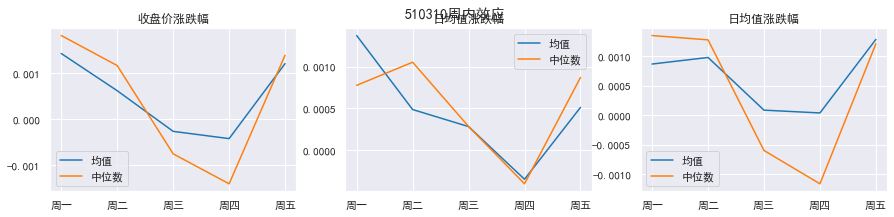

In [6]:
show_desc(data_qfq,False,plot_title='{}周内效应'.format(CODE))

In [7]:
def simple_test(data,plot=True,**kwargs):
    """
    **未考虑T+1交易的情况**
    Args:
        trade_func: 交易方法。用来在data中标记buy和sell。默认为None。
        plot_title: 绘图时的标题
    """
    dt=data.copy()
    dt['buy']=0
    dt['sell']=0
    trade_func=kwargs.pop('trade_func',None)
    trade_func_params=kwargs.pop('trade_func_params',{})
    if trade_func:
        trade_func(dt,**trade_func_params)
    dt['每日均价变更']=dt['avg_price'].pct_change()
    dt['每日开盘/收盘变更']=dt['close']/dt['open']-1
    dt['每日收盘价变更']=dt['close'].pct_change()
    # 持仓标记
    dt['hold']=dt['buy'].replace(0, np.NaN).fillna(method='ffill')
    dt.loc[(dt['hold']==1)&(dt['sell']==1),'hold']=np.NaN
    dt['hold'].fillna(0,inplace=True)
    #考虑A股T+1特性，去除前后hold均为0但当天hold为1的数据
    dt['hold_real']=dt['hold']
    dt.loc[(dt['hold_real']==1)&(dt['hold_real'].shift()==0)&(dt['hold_real'].shift(-1)==0),'hold_real']=0
    dt['策略-每日均价累加']=(dt['每日均价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日均价累加']=(dt['每日均价变更']*dt['hold_real']).cumsum()
    dt['基准-每日均价累加']=(dt['每日均价变更']).cumsum()
    dt['策略-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold_real']).cumsum()
    dt['基准-每日收盘价累加']=(dt['每日收盘价变更']).cumsum()
    if plot:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(dt.index,dt['策略-每日均价累加'],label='策略')
        ax1.plot(dt.index,dt['策略T+1-每日均价累加'],label='策略T+1')
        ax1.plot(dt.index,dt['基准-每日均价累加'],label='基准')
        ax1.legend()
        ax1.set_title("每日均价变更")
        ax2.plot(dt.index,dt['策略-每日收盘价累加'],label='策略')
        ax2.plot(dt.index,dt['策略T+1-每日收盘价累加'],label='策略T+1')
        ax2.plot(dt.index,dt['基准-每日收盘价累加'],label='基准')
        ax2.legend()
        ax2.set_title("每日收盘价变更")
    return dt

以`收盘价涨跌幅胜率`来看，应该跳过周三和周四两天。

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周二(1)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周四(3)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周五(4)|周一(0)、周二(1)、周五(4)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周三(2)、周四(3)|收盘价(close)|
|周二(1)|周三(2)、周四(3)|收盘价(close)|
|周三(2)|周三(2)、周四(3)|开盘价(open)|
|周四(3)|周三(2)、周四(3)|开盘价(open)|
|周五(4)|周三(2)、周四(3)|收盘价(close)|

In [8]:
def simple_trade_func(data,**kwargs):
    data.loc[data['nextday'].isin([0,1,4]),'buy']=1
    data.loc[~data['nextday'].isin([0,1,4]),'sell']=1
    return data

回归测试

实际操作过程中，稍稍跑赢基准而已。

In [9]:
def simple_buy_price_func(index, row, data):
    tom = data.iloc[data.index.get_loc(index)+1]
    if row['weekday'] in (0,1,4):
        return row['open']
    else:
        return row['close']

def simple_sell_price_func(index, row, data):
    if row['weekday'] in (0,1,4):
        return row['close']
    else:
        return row['open']

from gquant.backtest import backtest
x = get_data(CODE, START, END)
simple_trade_func(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1631it [00:01, 868.78it/s]


基准收益                           0.9073
策略收益                           1.0868
基准年化收益                         0.1391
策略年化收益                         0.1666
基准最大回撤                        -0.4562
策略最大回撤                        -0.4151
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.8451
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    2.0858
dtype: float64

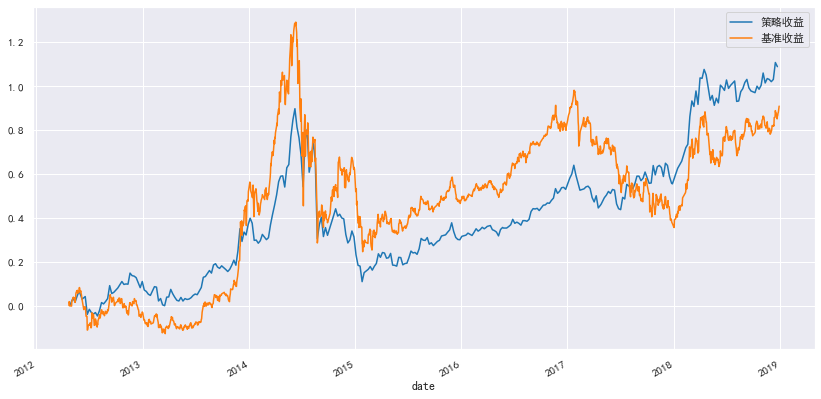

In [10]:
m.plot_cash()

下面考虑估计在上涨市（前日收盘价高于20日均线）、下跌市（前日收盘价低于20日均线）的市场中是否存在可以被利用的周内效应。

# 上涨市

In [11]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_up']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.27%,0.00%,-0.10%,-0.13%,0.15%
收盘价涨跌幅均值,0.27%,-0.01%,-0.04%,0.06%,0.14%
收盘价涨跌幅胜率,59.46%,46.97%,41.38%,41.92%,55.14%
日均值涨跌幅中位数,0.24%,0.20%,0.05%,-0.00%,0.20%
日均值涨跌幅均值,0.32%,0.25%,0.09%,0.11%,0.21%
日收盘相对开盘涨跌幅中位数,0.17%,0.00%,-0.06%,-0.10%,0.11%
日收盘相对开盘涨跌幅均值,0.22%,0.04%,-0.02%,0.08%,0.11%


以`收盘价涨跌幅胜率`来看，应该只在周一和周五持有股票

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周五(4)|开盘价(open)|
|周二(1)|周一(0)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周五(4)|收盘价(close)|
|周四(3)|周一(0)、周五(4)|收盘价(close)\*以中位数估算|
|周五(4)|周一(0)、周五(4)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周二(1)、周三(2)、周四(3)|收盘价(close)|
|周二(1)|周二(1)、周三(2)、周四(3)|收盘价(close)|
|周三(2)|周二(1)、周三(2)、周四(3)|开盘价(open)|
|周四(3)|周二(1)、周三(2)、周四(3)|开盘价(open)\*以中位数估算|
|周五(4)|周二(1)、周三(2)、周四(3)|收盘价(close)|

In [12]:
def _rasing_trade_fun_buy(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([0,4])),'buy']=1
    return data

def _rasing_trade_fun_sell(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([1,2,3])),'sell']=1
    return data

def rasing_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data.loc[data.shift()['up']!=True,'sell']=1
    return data

def rasing_buy_price_func(index, row, data):
    if row['weekday'] in (0,1,4):
        return row['open']
    else:
        return row['close']

def rasing_sell_price_func(index, row, data):
    if row['weekday'] in (0,1,4):
        return row['close']
    else:
        return row['open']

x = get_data(CODE, START, END)
rasing_trade_func_fix(x)
m = backtest(x, benchmark_pd=x[x['prev_up']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=rasing_buy_price_func, sell_price_func=rasing_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1631it [00:01, 1554.61it/s]


基准收益                           0.8998
策略收益                           0.5830
基准年化收益                         0.2321
策略年化收益                         0.1504
基准最大回撤                        -0.4383
策略最大回撤                        -0.1816
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.8795
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.5701
dtype: float64

回归测试

**实际操作过程中，远远低于基准。但是可以看到回撤降低非常多。**

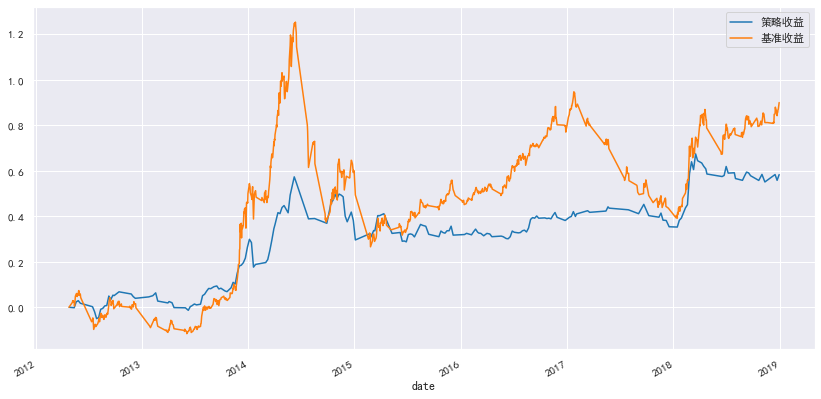

In [13]:
m.plot_cash()

# 下跌市

In [14]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_down']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.11%,0.34%,-0.06%,-0.15%,0.10%
收盘价涨跌幅均值,-0.03%,0.19%,-0.01%,-0.20%,0.10%
收盘价涨跌幅胜率,51.88%,62.60%,44.19%,38.46%,51.45%
日均值涨跌幅中位数,-0.19%,-0.08%,0.00%,-0.28%,-0.12%
日均值涨跌幅均值,-0.12%,-0.24%,-0.07%,-0.25%,-0.17%
日收盘相对开盘涨跌幅中位数,0.00%,0.25%,-0.06%,-0.17%,0.14%
日收盘相对开盘涨跌幅均值,-0.10%,0.21%,0.05%,-0.12%,0.15%


以`收盘价涨跌幅胜率`来看，应该只在周一、周二和周五持有股票。*周一要不要，还有待考虑*

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周二(1)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周二(1)、周五(4)|收盘价(close)\*以中位数估算|
|周四(3)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周五(4)|周一(0)、周二(1)、周五(4)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周三(2)、周四(3)|开盘价(open)|
|周二(1)|周三(2)、周四(3)|收盘价(close)|
|周三(2)|周三(2)、周四(3)|开盘价(open)\*以中位数估算|
|周四(3)|周三(2)、周四(3)|开盘价(open)|
|周五(4)|周三(2)、周四(3)|收盘价(close)|

In [15]:
def _falling_trade_func_buy(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([0,1,4])),'buy']=1
    return data

def _falling_trade_func_sell(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([2,3])),'sell']=1
    return data

def falling_trade_func(data,**kwargs):
    data=_falling_trade_func_buy(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    data.loc[data.shift()['down']!=True,'sell']=1
    return data

def falling_buy_price_func(index, row, data):
    if row['weekday'] in (0,2,3):
        return row['close']
    else:
        return row['open']

def falling_sell_price_func(index, row, data):
    if row['weekday'] in (0,2,3):
        return row['open']
    else:
        return row['close']

x = get_data(CODE, START, END)
falling_trade_func(x)
m = backtest(x, benchmark_pd=x[x['prev_down']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=falling_buy_price_func, sell_price_func=falling_sell_price_func)
m.stats()

1631it [00:00, 1825.60it/s]


基准收益                           0.7626
策略收益                           0.2997
基准年化收益                         0.2884
策略年化收益                         0.1134
基准最大回撤                        -0.4364
策略最大回撤                        -0.2660
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.8132
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.3213
dtype: float64

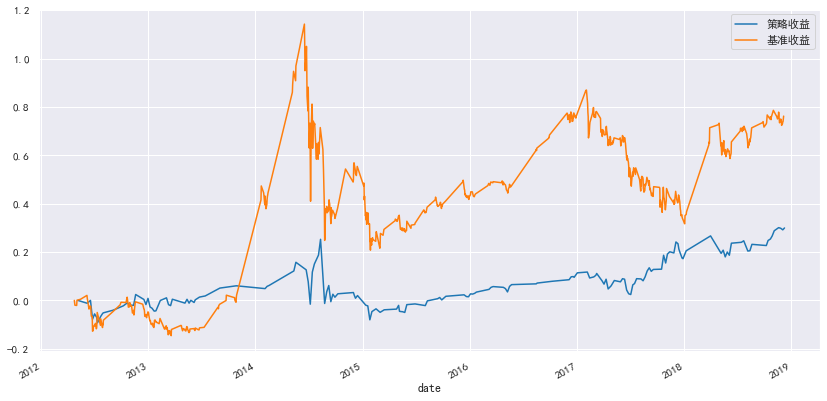

In [16]:
m.plot_cash()

---

# 合并上涨市和下跌市的买卖规则及买卖手法

In [17]:
def combine_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_falling_trade_func_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    return data

def combine_buy_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_buy_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_buy_price_func(index,row,data)

def combine_sell_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_sell_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_sell_price_func(index,row,data)


x = get_data(CODE, START, END)
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1631it [00:01, 943.81it/s] 


基准收益                           0.9073
策略收益                           1.3569
基准年化收益                         0.1391
策略年化收益                         0.2080
基准最大回撤                        -0.4562
策略最大回撤                        -0.3554
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.8451
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    2.3473
dtype: float64

😲  奇迹出现了！！！合并了上涨市和下跌市两种条件及购买卖出操作后，竟然收益竟然超过了基准。

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                     23472.5635
交易次数                       335.0000
未结束交易次数                      0.0000
未结束交易购买金额                    0.0000
未结束交易当前价值                    0.0000
盈利次数                       193.0000
亏损次数                       135.0000
盈利次数占比                       0.5761
盈利(含交易费)次数                 193.0000
亏损(含交易费)次数                 142.0000
盈利(含交易费)次数占比                 0.5761
盈利交易平均获利                   283.1855
亏损交易平均亏损                  -282.1807
盈利(含交易费)交易平均获利             283.1855
亏损(含交易费)交易平均亏损            -268.2704
盈亏总额                     16560.4000
手续费总额                     3087.8365
手续费均值                        4.6087
最大盈利%                        0.1370
最大亏损%                       -0.2116
最大(含交易费)盈利%                  0.1363
最大(含交易费)亏损%                 -0.2121
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.8451
结算价值(未结束交易当前价值+剩余现金)     23472.5635
浮动盈亏(结算价值/初始资金)              2.3473
dtype: float64


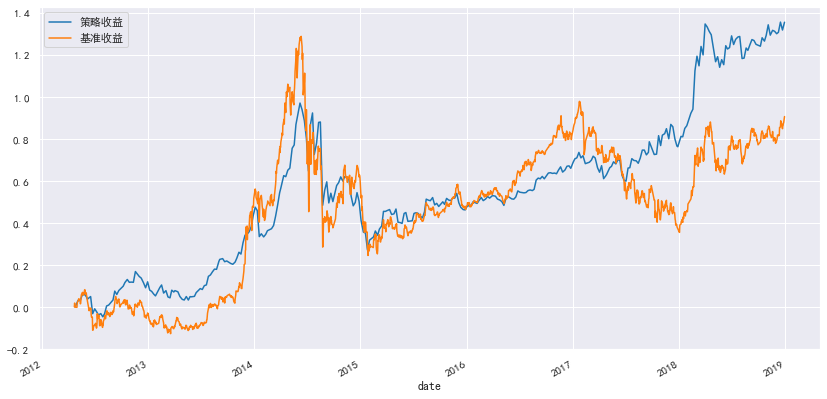

In [19]:
m.plot_cash()

---

# 盲测

In [20]:
x = get_data(CODE, '2019-12-01','2020-12-31')
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()

245it [00:00, 1102.01it/s]


基准收益                           0.3087
策略收益                           0.1809
基准年化收益                         0.3151
策略年化收益                         0.1846
基准最大回撤                        -0.1566
策略最大回撤                        -0.1380
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.3032
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.1705
dtype: float64

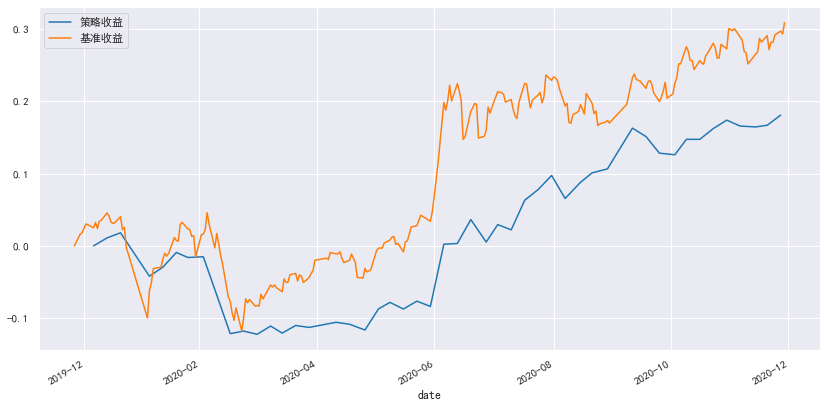

In [21]:
m.plot_cash()

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                     11705.1598
交易次数                        49.0000
未结束交易次数                      0.0000
未结束交易购买金额                    0.0000
未结束交易当前价值                    0.0000
盈利次数                        29.0000
亏损次数                        20.0000
盈利次数占比                       0.5918
盈利(含交易费)次数                  28.0000
亏损(含交易费)次数                  21.0000
盈利(含交易费)次数占比                 0.5714
盈利交易平均获利                   181.4069
亏损交易平均亏损                  -163.1100
盈利(含交易费)交易平均获利             187.7036
亏损(含交易费)交易平均亏损            -155.1000
盈亏总额                      1998.6000
手续费总额                      293.4402
手续费均值                        2.9943
最大盈利%                        0.0968
最大亏损%                       -0.0644
最大(含交易费)盈利%                  0.0961
最大(含交易费)亏损%                 -0.0649
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.3032
结算价值(未结束交易当前价值+剩余现金)     11705.1598
浮动盈亏(结算价值/初始资金)              1.1705
dtype: float64


从盲测结果来看，貌似又没那么美好。应该还是之前过度适应造成的，计算周内效应时使用的数据和回测时使用的数据是同一批数据，所以造成了此问题。后面尝试使用前3年的数据来判断后一年的结果试试看。

Text(0.5, 1.0, '下跌市-日收盘相对开盘涨跌幅中位数')

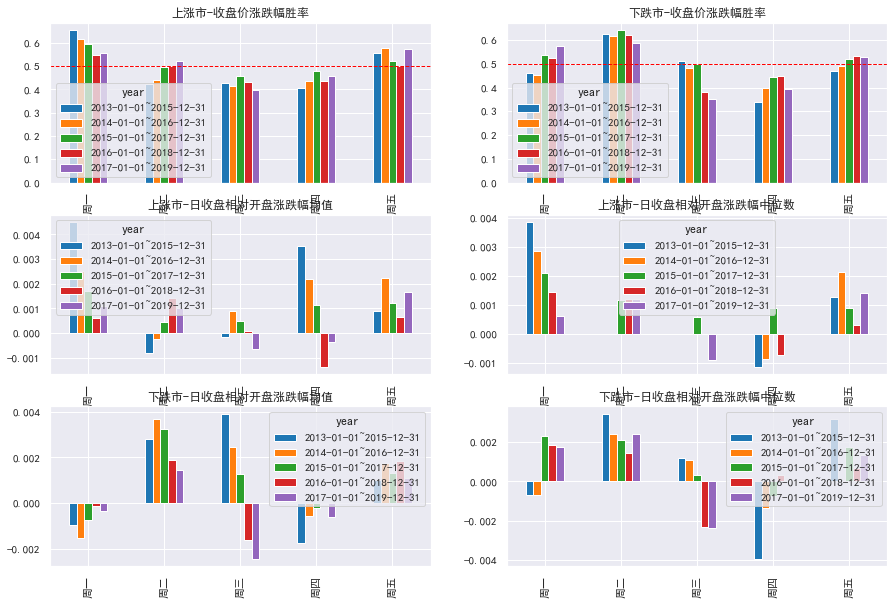

In [24]:
dfs_up=[]
dfs_down=[]
for i in range(2013,2018):
    start='{}-01-01'.format(i)
    end='{}-12-31'.format(i+2)
    data=get_data(CODE,start,end)
    df_up=get_desc(data[data['prev_up']==True]).T
    df_up['year']='{}~{}'.format(start,end)
    df_down=get_desc(data[data['prev_down']==True]).T
    df_down['year']='{}~{}'.format(start,end)
    dfs_up.append(df_up)
    dfs_down.append(df_down)
    
dfs_up=pd.concat(dfs_up)
dfs_down=pd.concat(dfs_down)

f = plt.figure(figsize=(15,10))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

# 日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数

dfs_up.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax1)
ax1.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax1.set_title("上涨市-收盘价涨跌幅胜率")
dfs_down.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax2)
ax2.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax2.set_title("下跌市-收盘价涨跌幅胜率")
dfs_up.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax3)
ax3.set_title("上涨市-日收盘相对开盘涨跌幅均值")
dfs_up.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax4)
ax4.set_title("上涨市-日收盘相对开盘涨跌幅中位数")
dfs_down.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax5)
ax5.set_title("下跌市-日收盘相对开盘涨跌幅均值")
dfs_down.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax6)
ax6.set_title("下跌市-日收盘相对开盘涨跌幅中位数")

从上图看来

* 上涨市时：周一获胜概率正在逐渐下降，而周二的获胜概率正在逐渐上升。以2017~2019年的测试结果来看，可以尝试在周一、周二、周五持有。以开盘价买入
* 下跌市时：同样周一、周二、周五三天的获胜概率均超过了50%

对比之前[盲测](#%E7%9B%B2%E6%B5%8B)的结果来说，收益率由`0.1809`提升至了`0.2155`(但是依然没有跑赢基准`0.3087`),最大回撤由`-0.1380`降低至`-0.1287`(基准`-0.1566`）。

---

# 循环回测

分别简单根据上图测试了自2015年至2020年的每年数据。发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以保持正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

In [25]:
def buy_2016(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (1, 2,4):
            return row['open']
        else:
            return row['close']


def sell_2016(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (1, 2,4):
            return row['close']
        else:
            return row['open']


def buy_2017(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1,4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (1,2,4):
            return row['open']
        else:
            return row['close']


def sell_2017(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1,4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (1,2,4):
            return row['close']
        else:
            return row['open']


def buy_2018(index, row, data):
    if row['prev_up'] == True:
        return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 2,4):
            return row['open']
        else:
            return row['close']
        
def sell_2018(index, row, data):
    if row['prev_up'] == True:
        return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 2,4):
            return row['close']
        else:
            return row['open']


def buy_2019(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1,2,4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 3,4):
            return row['open']
        else:
            return row['close']


def sell_2019(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1,2,4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 3,4):
            return row['close']
        else:
            return row['open']


def buy_2020(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1,4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1,4):
            return row['open']
        else:
            return row['close']


def sell_2020(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1,4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1,4):
            return row['close']
        else:
            return row['open']


x = get_data(CODE, '2001-12-01', '2021-12-31')

x4 = x['2016-01-01':'2016-12-31'].copy()
x4.loc[(x4['prev_up'] == True) & (x4['nextday'].isin([0,4])), 'buy'] = 1
x4.loc[(x4['prev_down'] == True) & (x4['nextday'].isin([1, 2])), 'buy'] = 1
x4.loc[(x4['prev_up'] == True) & (~x4['nextday'].isin([0,4])), 'sell'] = 1
x4.loc[(x4['prev_down'] == True) & (~x4['nextday'].isin([1, 2])),
       'sell'] = 1

x3 = x['2017-01-01':'2017-12-31'].copy()
x3.loc[(x3['prev_up'] == True) & (x3['nextday'].isin([0,4])), 'buy'] = 1
x3.loc[(x3['prev_down'] == True) & (x3['nextday'].isin([1])), 'buy'] = 1
x3.loc[(x3['prev_up'] == True) & (~x3['nextday'].isin([0,4])), 'sell'] = 1
x3.loc[(x3['prev_down'] == True) & (~x3['nextday'].isin([1])),
       'sell'] = 1

x2 = x['2018-01-01':'2018-12-31'].copy()
x2.loc[(x2['prev_up'] == True) & (x2['nextday'].isin([0, 1,4])), 'buy'] = 1
x2.loc[(x2['prev_down'] == True) & (x2['nextday'].isin([0, 1,4])), 'buy'] = 1
x2.loc[(x2['prev_up'] == True) & (~x2['nextday'].isin([0, 1,4])), 'sell'] = 1
x2.loc[(x2['prev_down'] == True) & (~x2['nextday'].isin([0, 1,4])), 'sell'] = 1

x1 = x['2019-01-01':'2019-12-31'].copy()
x1.loc[(x1['prev_up'] == True) & (x1['nextday'].isin([0, 1,4])), 'buy'] = 1
x1.loc[(x1['prev_down'] == True) & (x1['nextday'].isin([0, 1,4])), 'buy'] = 1
x1.loc[(x1['prev_up'] == True) & (~x1['nextday'].isin([0, 1,4])), 'sell'] = 1
x1.loc[(x1['prev_down'] == True) & (~x1['nextday'].isin([0, 1,4])), 'sell'] = 1

x5 = x['2020-01-01':'2020-12-31'].copy()
x5.loc[(x5['prev_up'] == True) & (x5['nextday'].isin([0, 1,4])), 'buy'] = 1
x5.loc[(x5['prev_down'] == True) & (x5['nextday'].isin([0, 1,4])), 'buy'] = 1
x5.loc[(x5['prev_up'] == True) & (~x5['nextday'].isin([0, 1,4])), 'sell'] = 1
x5.loc[(x5['prev_down'] == True) & (~x5['nextday'].isin([0, 1,4])), 'sell'] = 1

d={}
d['2016-01-01~2016-12-31']=backtest(x4,
             benchmark_pd=x4,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2016,
             sell_price_func=sell_2016)
d['2017-01-01~2017-12-31']=backtest(x3,
             benchmark_pd=x3,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2017,
             sell_price_func=sell_2017)
d['2018-01-01~2018-12-31']=backtest(x2,
             benchmark_pd=x2,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2018,
             sell_price_func=sell_2018)
d['2019-01-01~2019-12-31']=backtest(x1,
             benchmark_pd=x1,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2019,
             sell_price_func=sell_2019)
d['2020-01-01~2020-12-31']=backtest(x5,
             benchmark_pd=x5,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2020,
             sell_price_func=sell_2020)

every_year_stats = pd.DataFrame({k:v.stats() for k,v in d.items()}).T
every_year_reports = pd.DataFrame({k:v.report() for k,v in d.items()}).T

244it [00:00, 1002.83it/s]
244it [00:00, 1049.58it/s]
243it [00:00, 1063.93it/s]
244it [00:00, 1095.73it/s]
243it [00:00, 1076.67it/s]


In [33]:
print(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)']].cumsum().join(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)','盈利次数','亏损次数','未结束交易购买金额','未结束交易当前价值']],lsuffix='cumsum').join(every_year_stats.sort_index()[['基准最大回撤','策略最大回撤']]).to_markdown())

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |                                        0.908197 |                             1.11078 |                                  0.908197 |                      1.11078  |         31 |         21 |              11008   |              11080   |     -0.186782  |     -0.0649591 |
| 2017-01-01~2017-12-31 |                                        2.14141  |                             2.18985 |                                  1.23321  |                      1.07907  |         29 |        

In [30]:
print(every_year_stats.sort_index()[['基准收益','策略收益']].cumsum().join(every_year_stats.sort_index()[['基准收益','策略收益','基准最大回撤','策略最大回撤']],lsuffix='cumsum').to_markdown())

|                       |   基准收益cumsum |   策略收益cumsum |   基准收益 |   策略收益 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|-----------------:|-----------------:|-----------:|-----------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |       -0.0281367 |        0.0943142 | -0.0281367 |  0.0943142 |     -0.186782  |     -0.0649591 |
| 2017-01-01~2017-12-31 |        0.196789  |        0.16625   |  0.224926  |  0.0719358 |     -0.0617413 |     -0.023934  |
| 2018-01-01~2018-12-31 |       -0.0588706 |        0.100068  | -0.255659  | -0.0661819 |     -0.306485  |     -0.142651  |
| 2019-01-01~2019-12-31 |        0.350082  |        0.417115  |  0.408952  |  0.317047  |     -0.132188  |     -0.100598  |
| 2020-01-01~2020-12-31 |        0.645812  |        0.632618  |  0.295731  |  0.215503  |     -0.156608  |     -0.128704  |


In [31]:
every_year_reports

,初始资金,剩余现金,交易次数,未结束交易次数,未结束交易购买金额,未结束交易当前价值,盈利次数,亏损次数,盈利次数占比,盈利(含交易费)次数,...,盈亏总额,手续费总额,手续费均值,最大盈利%,最大亏损%,最大(含交易费)盈利%,最大(含交易费)亏损%,基准浮动盈亏(基准最后收盘/基准最先开盘),结算价值(未结束交易当前价值+剩余现金),浮动盈亏(结算价值/初始资金)
2016-01-01~2016-12-31,10000.0,27.8016,55.0,1.0,11008.0,11080.0,31.0,21.0,0.5636,31.0,...,1390.6,354.7984,3.2551,0.0506,-0.0573,0.0500,-0.0579,0.9082,11107.8016,1.1108
2017-01-01~2017-12-31,10000.0,30.2924,53.0,1.0,10684.8,10760.4,29.0,20.0,0.5472,29.0,...,1038.5,323.4076,3.0801,0.0283,-0.0149,0.0277,-0.0155,1.2332,10790.6924,1.0791
2018-01-01~2018-12-31,10000.0,9524.9061,50.0,0.0,0.0,0.0,25.0,25.0,0.5000,25.0,...,-183.7,291.3939,2.9139,0.0520,-0.0410,0.0513,-0.0416,0.7610,9524.9061,0.9525
2019-01-01~2019-12-31,10000.0,13434.8169,49.0,0.0,0.0,0.0,29.0,20.0,0.5918,29.0,...,3793.3,358.4830,3.6580,0.0738,-0.0562,0.0732,-0.0568,1.3879,13434.8169,1.3435
2020-01-01~2020-12-31,10000.0,89.7279,50.0,1.0,12076.8,12076.8,31.0,18.0,0.6200,31.0,...,2473.2,306.6721,3.0977,0.0870,-0.0644,0.0864,-0.0649,1.2961,12166.5279,1.2167
